In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
import gymnasium as gym

from FFNN import FFNN
from blackjackenv_extended import BlackjackEnv

from random_agent import RandomAgent
from basic_strategy_agent import BasicStrategyAgent
from backprop_agent import BackpropAgent
from FFNN_agent import FFNNAgent
from DQFFNN_BJ_agent import DQFFNNAgentBJ
from DQFFNN_agent import DQFFNNAgent

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("using gpu: ", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("using cpu")

seed = 43
np.random.seed(seed)

using cpu


## Blackjack

In [67]:
env = BlackjackEnv(natural=True)

episodes = 1001
collect_data = True

In [24]:
KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE', 3: 'SPLIT'}

def one_hot_encode(observation, n):
    one_hot = np.zeros(n)
    one_hot[observation] = 1
    return one_hot

def play_game(env, episodes, agent, collect_data=False, print_rewards=True, OH_encode=False):
    rewards = []

    for episode in tqdm(range(episodes)):
        observation, info = env.reset()
        done = False
        
        # print(f"Episode: {episode+1}/{episodes}")
        # print("-"*40)
        # print("hand 1", env.player)
        # print("hand 2", env.player2)
        # print("Start Observation: ", observation)
        
        
        while not done:
            if OH_encode:
                observation = one_hot_encode(observation, env.observation_space.n)
            
            action = agent.get_action(observation)
            #print("Action: ", KEY[action])

            # save data for training
            if collect_data:
                agent.collect_data(observation, action)
            
            next_observation, reward, terminated, truncated, info = env.step(action) 
            
            if OH_encode:
                agent.learn(observation, 
                            action, 
                            reward, 
                            one_hot_encode(next_observation, env.observation_space.n), 
                            terminated or truncated)
            else:  
                agent.learn(observation, action, reward, next_observation, terminated or truncated)
            observation = next_observation
            
            # print("hand 1", env.player)
            # print("hand 2", env.player2)
            # print("Observation: ", observation, "Reward: ", reward)
            

            if terminated or truncated:
                # print(f"Dealer hand: ", env.dealer)
                rewards.append(reward)
                observation = env.reset()
                done = True
        
        agent.decay_epsilon()    

    if collect_data:
        agent.save_data()
    
    average_reward = sum(rewards)/episodes
    variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

    if print_rewards:
        #print("Rewards: ", rewards)
        print("Average Reward: ", average_reward)
        print("Variance: ", variance)
    
    return rewards

In [73]:
def plot_reward(data, title, filename, labels, plot_variance=False, rolling_length=1000):
    data = np.array(data)
    np.savetxt(f'../data/{filename}_rewards.csv', data.reshape(data.shape[0], -1), delimiter=',')
    
    _, ax = plt.subplots()
    
    rolling_mean = np.zeros((len(data), len(data[0]) - (rolling_length - 1))) 
    for i in range(len(data)):
        rolling_mean[i] = (np.convolve(np.array(data[i]).flatten(), np.ones(rolling_length), mode="valid")
            / rolling_length)
            
    if plot_variance:
        mean = rolling_mean.mean(axis=0)
        variance = rolling_mean.var(axis=0)
        upper_bound_sd = mean + np.sqrt(variance)
        lower_bound_sd = mean - np.sqrt(variance)
        plt.plot(mean, label='Mean', color='blue')
        plt.fill_between(range(len(mean)),upper_bound_sd, lower_bound_sd, alpha=0.2, label='Standard Deviation')
    else:
        for i in range(len(data)):
            ax.plot(rolling_mean[i], label=labels[i])

    plt.ylabel("Reward")
    plt.xlabel("Episodes")
    plt.legend()
    plt.savefig(f"../figures/{filename}_rewards.png", dpi='figure', format=None)
    plt.show()

### Random & Basic Agents

100%|██████████| 2000/2000 [00:00<00:00, 7654.29it/s]


Average Reward:  -0.466
Variance:  1.536362181090516


100%|██████████| 2000/2000 [00:00<00:00, 7445.36it/s]


Average Reward:  -0.0165
Variance:  1.2768661830915424


FileNotFoundError: [Errno 2] No such file or directory: '../figures/random_basic_strategy_rewards.png'

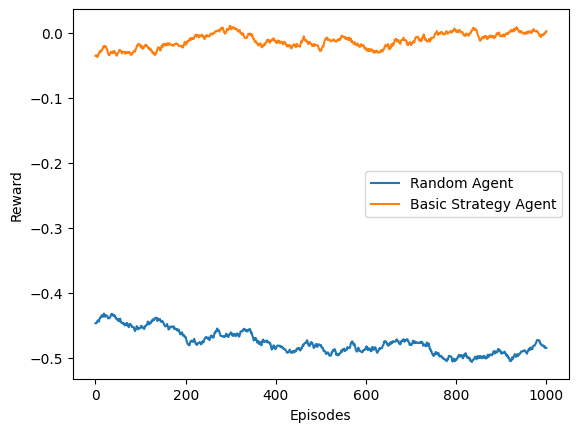

In [74]:
agent = RandomAgent(env, filename="random_agent")
rewards_random = play_game(env, episodes, agent, collect_data)


agent = BasicStrategyAgent(env, filename="basic_strategy_agent")
rewards_basic_strategy = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_random, rewards_basic_strategy], "Random vs Basic Strategy Agent", "random_basic_strategy", ["Random Agent", "Basic Strategy Agent"])

## Data Generation

### Simulated Data

In [52]:
def read_data(file):
    return pd.read_csv(file, delimiter=',')

In [53]:
def split_data(data):
    x = data[:, :5]
    y = data[:, 5]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    return x_train, x_test, y_train, y_test

def transform(data):
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [54]:
def preprocess(filename):
    df_raw = read_data(filename)
    print(df_raw.head())
    d_raw = df_raw.to_numpy() # data to binary?
    x, x_test, y, y_test = split_data(d_raw)
    x, x_test = transform(x), transform(x_test)
    
    return x, x_test, y, y_test

In [55]:
datafile = '../data/basic_strategy_agent.csv'
x_train, x_test, y_train, y_test = preprocess(datafile)

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0          20            7           0                    1              1   
1           8            2           0                    1              0   
2          18            2           0                    0              0   
3          12            1           0                    1              0   
4          14            1           0                    0              0   

   Action  
0       0  
1       1  
2       0  
3       1  
4       1  


In [56]:
def one_hot_encode(y, n):
    return torch.eye(n)[y]

def combine_input_and_label(x, y, n):
    y_one_hot = one_hot_encode(y, n)
    return torch.concat((x, y_one_hot), 1)

def generate_neg_labels(y, n):
    y_ = y.copy()
    for i in range(len(y)):
        negative_labels = [j for j in range(n) if j != y[i]]
        y_[i] = np.random.choice(negative_labels)

    return y_

In [57]:
x_pos = combine_input_and_label(x_train, y_train, 4)

y_neg = generate_neg_labels(y_train, 4)
x_neg = combine_input_and_label(x_train, y_neg, 4)

y_train_OH = one_hot_encode(y_train, 4)
y_test_OH = one_hot_encode(y_test, 4)

print(f"x_pos[0]: {x_pos[0]}")
print(f"x_neg[0]: {x_neg[0]}")
print(f"Train size: {len(x_train)}")
print(f"Test size: {len(x_test)}")

x_pos[0]: tensor([ 8., 10.,  0.,  1.,  1.,  0.,  1.,  0.,  0.])
x_neg[0]: tensor([ 8., 10.,  0.,  1.,  1.,  0.,  0.,  0.,  1.])
Train size: 71
Test size: 18


### Balanced Data

In [36]:
env = BlackjackEnv(natural=True)
basic_strategy_agent = BasicStrategyAgent(env, filename='../data/blackjack_combinations')

def create_combinations():
    for player_hand in range(4, 22):
        for dealer_hand in range(2, 12):
            for usable_ace in range(2):
                for can_double_down in range(2):
                    for can_split in range(2):
                        observation = (player_hand, dealer_hand, usable_ace, can_double_down, can_split)
                        if (dealer_hand == 11 and usable_ace) == 1:
                            # impossible combination    
                            continue
                        action = basic_strategy_agent.get_action(observation)
                        basic_strategy_agent.collect_data(observation, action)
    
    basic_strategy_agent.save_data()
                        
            
def get_combinations_for_action(action):
    samples = []
    with open('../data/blackjack_combinations.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if int(row[-1]) == action:
                samples.append(row)
    return samples

def sample_balanced_data(n_samples):
    data = []
    combinations = np.empty(4, dtype=object)
    
    for action in range(4):
        combinations[action] = get_combinations_for_action(action)
        
        for i in range(n_samples):
            sample_idx = np.random.choice(len(combinations[action]))
            data.append(combinations[action][sample_idx])

    with open('../data/balanced_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        
        writer.writerow(["Player sum", "Dealer card", "Usable ace", "Double down allowed", "Split allowed", "Action"])
        writer.writerows(data)

In [58]:
create_combinations()
samples_per_action = 20
sample_balanced_data(samples_per_action)

In [59]:
datafile = '../data/balanced_data.csv'
x_train_bal, x_test_bal, y_train_bal, y_test_bal = preprocess(datafile)

x_pos_bal = combine_input_and_label(x_train_bal, y_train_bal, 4)

y_neg_bal = generate_neg_labels(y_train_bal, 4)
x_neg_bal = combine_input_and_label(x_train_bal, y_neg_bal, 4)

y_train_OH_bal = one_hot_encode(y_train_bal, 4)
y_test_OH_bal = one_hot_encode(y_test_bal, 4)


print(f"\nx_pos[0]: {x_pos_bal[0]}")
print(f"x_neg[0]: {x_neg_bal[0]}")
print(f"\nTrain size: {len(x_train_bal)}")
print(f"Test size: {len(x_test_bal)}")

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0          17            9           0                    1              0   
1          21            4           1                    0              1   
2          18           10           0                    1              1   
3          18            7           1                    0              1   
4          18            9           0                    0              0   

   Action  
0       0  
1       0  
2       0  
3       0  
4       0  

x_pos[0]: tensor([11.,  6.,  0.,  1.,  0.,  0.,  0.,  1.,  0.])
x_neg[0]: tensor([11.,  6.,  0.,  1.,  0.,  0.,  1.,  0.,  0.])

Train size: 64
Test size: 16


## Forward-Forward

In [71]:
def print_accuracy(model_predictions, y):
    predictions = np.array(torch.Tensor.cpu(model_predictions)).flatten()
    accuracy =  model_predictions.eq(torch.from_numpy(y).to(device)).float().mean().item()
    
    print(y)
    print(predictions)
    print(f'Accuracy: {accuracy}')

    ConfusionMatrixDisplay.from_predictions(y, predictions, normalize="true")
    
def plot_losses(data, title, filename):
    np.savetxt(f'../data/{filename}_losses.csv', data, delimiter=',')

    plt.plot(np.array(data))

    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title(title)
    plt.savefig(f"../figures/{filename}_losses.png", dpi='figure', format=None)
    plt.show()

### Balanced Data FFNN

In [61]:
# Hyperparameters
layers = [9, 2000, 2000, 2000, 2000]
threshold = 0.5
learning_rate = 0.001
epochs = 120
batch_size = 64
lr_decay = False

model = FFNN(
    device=device,
    layers=layers,
    threshold=threshold,
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    ).to(device)


In [62]:
last_layer_losses = model.train(x_pos_bal, x_neg_bal)
model.save_model('../models/model_balanced.pth')


Training Layer: 1
----------------------------------------


100%|██████████| 120/120 [00:00<00:00, 461.58it/s]



Training Layer: 2
----------------------------------------


100%|██████████| 120/120 [00:07<00:00, 15.38it/s]



Training Layer: 3
----------------------------------------


100%|██████████| 120/120 [00:07<00:00, 16.13it/s]



Training Layer: 4
----------------------------------------


100%|██████████| 120/120 [00:07<00:00, 16.45it/s]


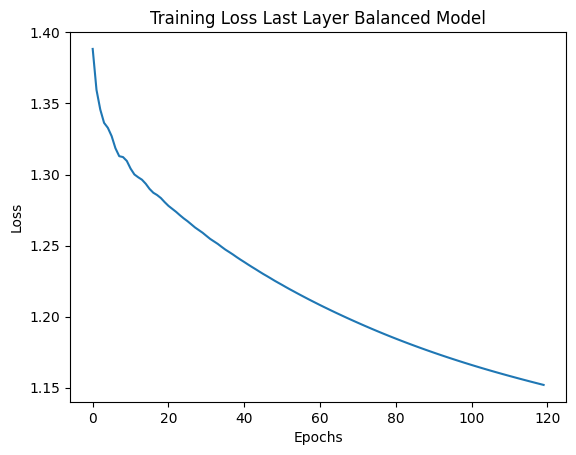

[1 1 3 3 0 0 1 2 3 3 0 0 0 2 2 0]
[2 3 2 2 2 3 2 2 1 1 2 1 1 2 3 2]
Accuracy: 0.125


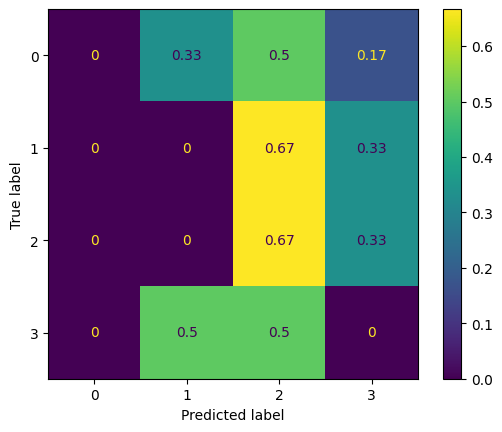

In [63]:
plot_losses(last_layer_losses, "Training Loss Last Layer Balanced Model", "model_balanced")
print_accuracy(model.predict_accumulated_goodness(x_test_bal), y_test_bal)

### FFNN

In [64]:
def cross_validation(x_pos, x_neg,architectures, thresholds, learning_rates, n_epochs, n_folds, batch_sizes, lr_decays):
    
    size_subset = len(x_pos) // n_folds
    validation_risks = []
    
    for architecture in tqdm(architectures):
        for threshold in thresholds:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for lr_decay in lr_decays:
                        #print("-"*40)
                        print(f"Current Model:{architecture}, thr={threshold}, lr={lr}, batch_size={batch_size}, lr_decay={lr_decay}")
                        val_risks_model = []
                        
                        for fold in range(n_folds):
                            #print(f"Fold {fold}")
                            #print("-"*40)
                            
                            # Split data into training and validation
                            start_idx = fold * size_subset
                            end_idx = (fold + 1) * size_subset
                            x_pos_train = torch.cat((x_pos[:start_idx], x_pos[end_idx:]))
                            x_neg_train = torch.cat((x_neg[:start_idx], x_neg[end_idx:]))
                            x_val = x_train[start_idx:end_idx]
                            y_val = y_train[start_idx:end_idx]
                            
                            # Initialize current model
                            model = FFNN(
                                device=device,
                                layers=architecture,
                                bias=True,
                                threshold=threshold,
                                learning_rate=lr,
                                epochs=n_epochs,
                                batch_size=batch_size,
                                lr_decay=lr_decay,
                                verbose=False
                            ).to(device)
                            
                            # Train model
                            model.train(x_pos_train, x_neg_train)
                            
                            # Compute validation risk
                            predictions = model.predict_accumulated_goodness(x_val) # juiste risk?
                            val_risk = 1 - predictions.eq(torch.from_numpy(y_val).to(device)).float().mean().item()
                            val_risks_model.append(val_risk)
                            
                            #print(f"\n validation risk: {val_risk}")
                            
                        avg_val_risk = np.mean(val_risks_model)
                        validation_risks.append((architecture, threshold, lr, batch_size, lr_decay, avg_val_risk ))
                        #model.save_model(f'../models/model_{architecture}_{threshold}_{lr}_{avg_val_risk}.pth')
                        
                        with open('../data/cxv_results.csv', 'a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow([architecture, threshold, lr, batch_size, lr_decay, avg_val_risk])
                            
                        #print(f"validation risks for model {architecture}, thr={threshold}, lr={lr}: {val_risks_model}")
                        print(f"average validation risk: {avg_val_risk}")
                        print("-"*40)
    
    print("total validation risks:" , validation_risks)  
    min_risk_model = min(validation_risks, key=lambda x: x[-1])
    print(f"Best model: {min_risk_model}")   
    return min_risk_model               

In [65]:
# Hyperparameters
architectures = [
    [9,30,30],
    [9,100,100],
    [9,500,500],
    [9,100,100,100],
    [9,200,200,200],
    [9,1000,1000,1000],
    [9,2000,2000,2000,2000],
]
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 3, 5, 7]
learning_rates = [0.0001,0.001,0.01,0.03]
n_epochs = 240
n_folds = 10
batch_sizes = [32, 64, 500, len(x_train)]
lr_decays = [0, 1]

best_model = cross_validation(
    x_pos, 
    x_neg, 
    architectures,
    thresholds,
    learning_rates,
    n_epochs,
    n_folds,
    batch_sizes,
    lr_decays
)

  0%|          | 0/1 [00:00<?, ?it/s]

Current Model:[9, 30, 30], thr=0.3, lr=0.0001, batch_size=32, lr_decay=0
average validation risk: 0.4428571298718452
----------------------------------------
Current Model:[9, 30, 30], thr=0.3, lr=0.0001, batch_size=32, lr_decay=1
average validation risk: 0.328571417927742
----------------------------------------
Current Model:[9, 30, 30], thr=0.3, lr=0.0001, batch_size=64, lr_decay=0
average validation risk: 0.5571428447961807
----------------------------------------
Current Model:[9, 30, 30], thr=0.3, lr=0.0001, batch_size=64, lr_decay=1
average validation risk: 0.5428571358323098
----------------------------------------
Current Model:[9, 30, 30], thr=0.3, lr=0.0001, batch_size=500, lr_decay=0
average validation risk: 0.814285708963871
----------------------------------------
Current Model:[9, 30, 30], thr=0.3, lr=0.0001, batch_size=500, lr_decay=1
average validation risk: 0.8142857104539871
----------------------------------------
Current Model:[9, 30, 30], thr=0.3, lr=0.0001, batch

  0%|          | 0/1 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [66]:
# Best model hyperparameters
architecture_best = best_model[0]
threshold_best = best_model[1]
learning_rate_best = best_model[2]
epochs = 240 #1000?
batch_size = best_model[3]
lr_decay = best_model[4]

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}, batch_size={batch_size}, lr_decay={lr_decay}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay
).to(device)

NameError: name 'best_model' is not defined

In [19]:
last_layer_losses = model.train(x_pos, x_neg)
model.save_model('../models/best_model.pth')

100%|██████████| 1000/1000 [00:01<00:00, 717.59it/s]


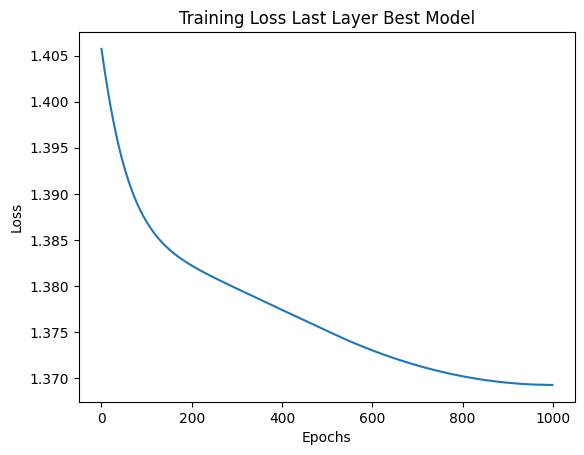

[0 0 0 0 0 0]
[0 0 0 0 0 0]
Accuracy: 1.0


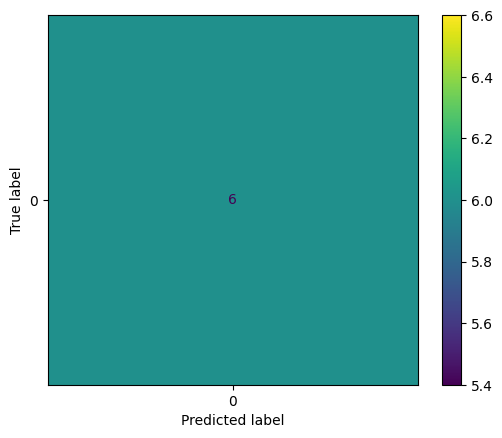

In [20]:
print_accuracy(model.predict_accumulated_goodness(x_test), y_test)
plot_losses(last_layer_losses, "Training Loss Last Layer Best Model", "best_model")


### FFNN with Softmax Classifier

In [21]:
architecture_best = best_model[0]
threshold_best = best_model[1]
learning_rate_best = best_model[2]
batch_size = best_model[3]
lr_decay = best_model[4]

# Create equal model with classifier
model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    classifier=True
).to(device)

model.load_model('../models/best_model.pth')

In [22]:
classifier_layer_loss = model.train_classifier(x_train, y_train_OH, epochs, batch_size)
torch.save(model.classifier.state_dict(), '../models/softmax_model_classifier.pth')


Training Softmax
----------------------------------------


100%|██████████| 120/120 [00:00<00:00, 421.63it/s]

Last epoch loss: 1.4525036811828613


[0 0 0 0 0 0]
[1 1 1 1 1 1]
Accuracy: 0.0


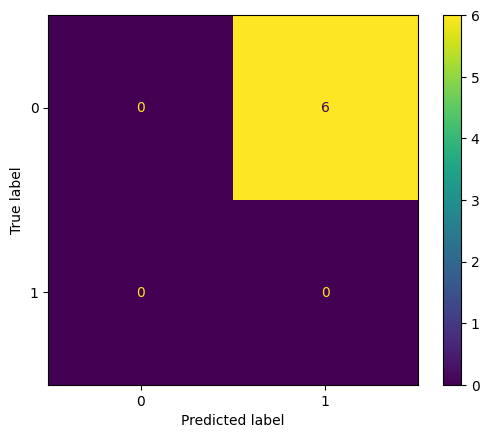

In [24]:
plot_losses(classifier_layer_loss, "Training Loss Classifier", "classifier")
print_accuracy(model.predict_classifier(x_test),y_test)

In [12]:
# testing!

# Best model hyperparameters
architecture_best = [9,100,100,100]
threshold_best = 0.5
learning_rate_best = 0.03
epochs = 200
batch_size = 1
lr_decay = False

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    classifier=True
).to(device)

model.train(x_pos, x_neg)
classifier_layer_loss = model.train_classifier(x_train, y_train_OH, epochs, batch_size=5)
model.save_model('../models/softmax_model.pth')
torch.save(model.classifier.state_dict(), '../models/softmax_model_classifier.pth')

Best model: [9, 100, 100, 100], thr=0.5, lr=0.03

Training Layer: 1
----------------------------------------


100%|██████████| 200/200 [00:02<00:00, 70.19it/s]



Training Layer: 2
----------------------------------------


100%|██████████| 200/200 [00:03<00:00, 59.31it/s]



Training Layer: 3
----------------------------------------


100%|██████████| 200/200 [00:03<00:00, 63.17it/s]



Training Softmax
----------------------------------------


100%|██████████| 200/200 [00:00<00:00, 623.32it/s]

Last epoch loss: 0.5441149398684502


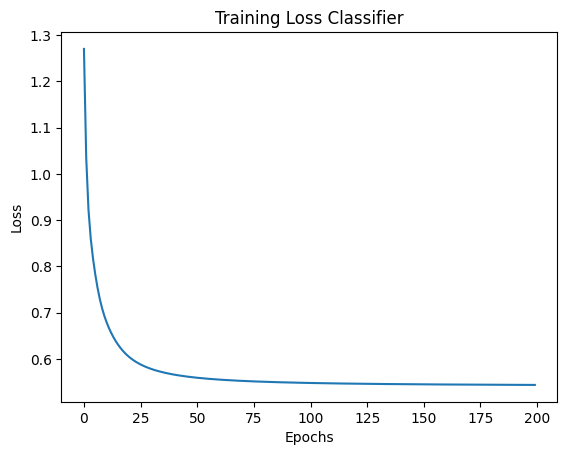

[0 0 0 0 1 0 0 0 1 0 1 3 1 1 0 1 2 0 0 0 1 1]
[1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1]
Accuracy: 0.7272727489471436


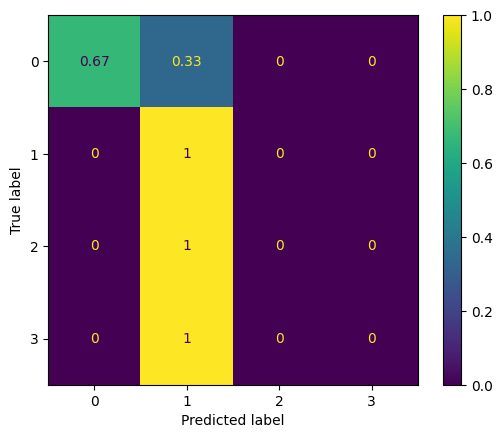

In [18]:
plot_losses(classifier_layer_loss, "Training Loss Classifier", "classifier")
print_accuracy(model.predict_classifier(x_train.to(device)),y_train)

## Backpropagation

In [25]:
def train(model, x, y, epochs, loss_function, optimizer, batch_size):
    
    model.train()
    num_batches = len(x) // batch_size
    
    for epoch in range(epochs):
        losses = []
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f"epoch: {epoch + 1}/{epochs} avg. loss: {sum(losses)/len(losses)}")

In [26]:
def test(model, x_test, y_test, loss_function):
    
    model.eval()
    
    with torch.no_grad():
        predictions = model(x_test)
        test_loss = loss_function(predictions, y_test).item()
        
    print(f"avg. test loss: {test_loss}")   
    
def predict_actions(model, x):
    model.eval()
    
    with torch.no_grad():
        predictions = model(x)
        return predictions.argmax(1)

In [27]:
from backpropNN import BackpropNN

input_size = 5
output_size = 4

# hyperparameters
hidden_size = 30
activation_function = nn.ReLU()

# fully connected neural network with 4 hidden layers
backprop_model = BackpropNN(input_size, output_size, hidden_size, activation_function)

In [29]:
# hyperparameters
epochs = 60 #100?
batch_size = 64
learning_rate = 0.001

optimizer = torch.optim.Adam(backprop_model.parameters(), lr=learning_rate);
loss_fn = nn.CrossEntropyLoss()

train(backprop_model, x_train, y_train_OH, epochs, loss_fn, optimizer, batch_size)
torch.save(backprop_model.state_dict(), '../models/backprop_model.pth')

epoch: 1/100 avg. loss: 1.3811665773391724
epoch: 2/100 avg. loss: 1.357580542564392
epoch: 3/100 avg. loss: 1.334404468536377
epoch: 4/100 avg. loss: 1.311065435409546
epoch: 5/100 avg. loss: 1.2879376411437988
epoch: 6/100 avg. loss: 1.26528799533844
epoch: 7/100 avg. loss: 1.2429842948913574
epoch: 8/100 avg. loss: 1.2205528020858765
epoch: 9/100 avg. loss: 1.1978294849395752
epoch: 10/100 avg. loss: 1.1748849153518677
epoch: 11/100 avg. loss: 1.1524611711502075
epoch: 12/100 avg. loss: 1.1310367584228516
epoch: 13/100 avg. loss: 1.110477328300476
epoch: 14/100 avg. loss: 1.0900460481643677
epoch: 15/100 avg. loss: 1.0695176124572754
epoch: 16/100 avg. loss: 1.0487796068191528
epoch: 17/100 avg. loss: 1.0281648635864258
epoch: 18/100 avg. loss: 1.0079175233840942
epoch: 19/100 avg. loss: 0.9884127974510193
epoch: 20/100 avg. loss: 0.9698008894920349
epoch: 21/100 avg. loss: 0.9519705176353455
epoch: 22/100 avg. loss: 0.9350654482841492
epoch: 23/100 avg. loss: 0.9194095730781555
epo

In [30]:
test(backprop_model, x_test, y_test_OH, loss_fn)

avg. test loss: 0.047363728284835815


In [31]:
# print(torch.from_numpy(y_test))
# print(predict_action(backprop_model, x_test))
accuracy = predict_actions(backprop_model, x_test).eq(torch.from_numpy(y_test)).float().mean().item() # heet dit accuracy?
print(accuracy)

1.0


## FFNN Blackjack

### FFNN & Backpropagation

In [68]:
# FFNN hyperparameters
model_path = '../models/best_model.pth'
layers = best_model[0]
threshold = best_model[1]
lr = best_model[2]

agent = FFNNAgent(
    env,
    model_path=model_path,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    filename="ffnn_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_FFNN, rewards_random], "FFNN Agent", "ffnn_random_agent", ["FFNN Agent", "Random Agent"])

NameError: name 'best_model' is not defined

100%|██████████| 10000/10000 [00:06<00:00, 1530.05it/s]


Average Reward:  -0.0039
Variance:  1.2864134313432152


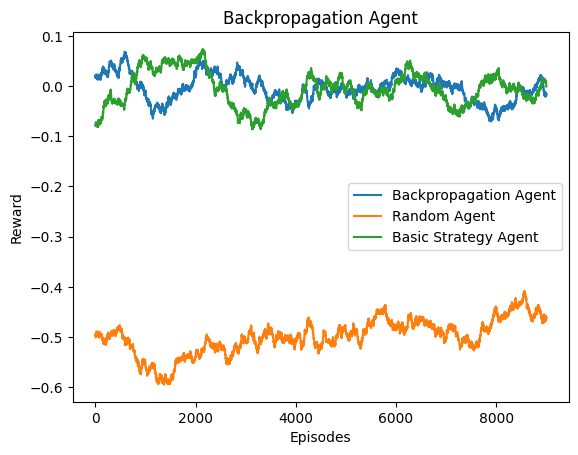

In [ ]:
# Backprop hyperparameters
input_size = 5
output_size = 4
hidden_size = 30
activation_fn = nn.ReLU()

agent = BackpropAgent(
    env, 
    model=torch.load('../models/backprop_model.pth'),
    input_size=input_size, 
    output_size=output_size, 
    hidden_size=hidden_size, 
    activation_fn=activation_fn,
    filename="backprop_agent"
)

rewards_BP = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_BP, rewards_random], "Backpropagation Agent", "backprop_random_agent", ["Backpropagation Agent", "Basic Strategy Agent"])
plot_reward([rewards_BP, rewards_random, rewards_basic_strategy], "Backpropagation Agent", "backprop_random_basic_agent", ["Backpropagation Agent", "Random Agent", "Basic Strategy Agent"])

### DQFFL

In [75]:
# DQFFL hyperparameters
layers = [9,1000,1000,1000]
threshold = 0.5
lr = 0.001

#RL hyperparameters
episodes = 2000 
epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.99
batch_size = 32
update_td_target = 50
buffer_size = 10000

total_rewards = []
for i in range(5):
    print(f"\nRun {i+1}")
    print("-"*40)
    agent = DQFFNNAgentBJ(
        env,
        device=device,
        layers=layers,
        threshold=threshold,
        lr=lr,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        discount_factor=discount_factor,
        batch_size=batch_size,
        update_td_target=update_td_target,
        buffer_size=buffer_size,
        filename="dqffnn_agent"
    )
    rewards_DQFFNN = play_game(env, episodes, agent, collect_data, print_rewards=False)
    total_rewards.append(rewards_DQFFNN)
    
agent.model.save_model(path='../models/DQFFNN_model.pth')
plot_reward([rewards_DQFFNN, rewards_random], "DQFFNN Agent", f"DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}_random_agent", ["DQFFNN Agent", "Random Agent"])
plot_reward(total_rewards, "DQFFNN Agent", f"DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}", ["DQFFNN Agent"], plot_variance=True, rolling_length=100)


Run 1
----------------------------------------


  2%|▏         | 42/2000 [00:01<01:25, 22.81it/s] 


KeyboardInterrupt: 

[0 0 0 0 0 0]
[0 1 0 0 0 0]
Accuracy: 0.8333333134651184


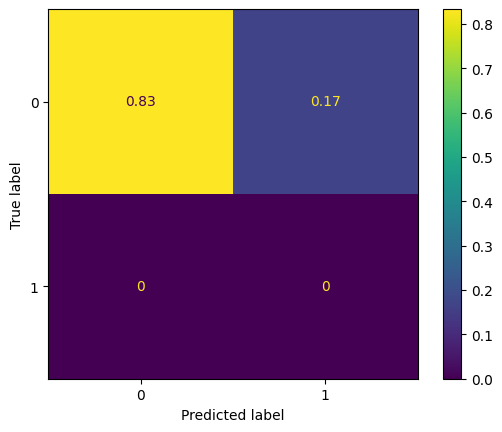

In [41]:
print_accuracy(agent.model.predict_accumulated_goodness(x_test), y_test)

#### Frozen Lake

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [02:17<00:00, 14.49it/s]


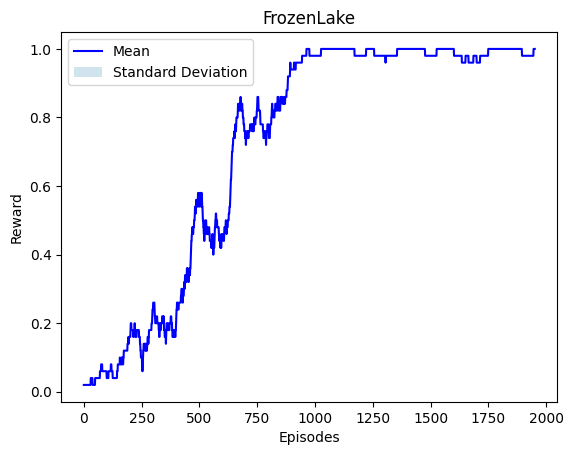

In [18]:
layers = [20,100,100,100]
threshold = 0.5
lr = 0.001

#RL hyperparameters
episodes = 2000
epsilon = 0.99
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.9
batch_size = 32
update_td_target = 10
buffer_size = 1000

env = gym.make("FrozenLake-v1", max_episode_steps=100, desc=None, map_name="4x4", is_slippery=False)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)


total_rewards = []
for i in range(5):
    print(f"\nRun {i+1}")
    print("-"*40)
    agent = DQFFNNAgent(
        env,
        device=device,
        layers=layers,
        threshold=threshold,
        lr=lr,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        discount_factor=discount_factor,
        batch_size=batch_size,
        update_td_target=update_td_target,
        buffer_size=buffer_size
    )

    play_game(env, episodes, agent, False, False, True)
    rewards = np.array(env.return_queue).flatten()
    total_rewards.append(rewards)

average_reward = sum(rewards)/episodes
variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)
agent.model.save_model(path='../models/FrozenLake_DQFFNN_model.pth')

#print("Rewards: ", rewards)
# print("Average Reward: ", average_reward)
# print("Variance: ", variance)
plot_reward(total_rewards, "FrozenLake", f"FrozenLake_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}", ["Frozen Lake"],plot_variance=True , rolling_length=50)